In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from dataset import get_loaders
from models.aelstm import AELSTM

In [2]:
DEVICE="cuda"
WINDOW=32
BATCH_SIZE=32
LR=1e-4
EPOCHS=10
LATENT_DIM=64

In [3]:
trainloader, testloader = get_loaders(root='data', window_size=WINDOW, batch_size=BATCH_SIZE)

In [4]:
model = AELSTM(input_dim=123, hidden_size=256, latent_dim=LATENT_DIM).to(DEVICE)

In [5]:
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [ ]:
model.train()

pbar = range(EPOCHS)
for epoch in pbar:
        
    curr_loss = 0
    for x, label in tqdm(trainloader):
        x = x.to(DEVICE)
        targets = x[:, -1, :]
        optimizer.zero_grad()
        rec = model(x)
        loss = criterion(rec, targets)
        curr_loss+=loss.item()
            
        loss.backward()
        optimizer.step()

    print(f"For epoch {epoch+1}/{EPOCHS} ; loss : {curr_loss/len(trainloader)}")

checkpoint = {"state_dict":model.state_dict()}
torch.save(checkpoint, 'checkpoints/aelstm.pkl')

In [7]:
test_loss = []
labels = []

model.eval()
with torch.no_grad():
    for x, label in tqdm(testloader):
        x = x.to(DEVICE)
        target = x[:,-1,:]
        rec = model(x)
        error = torch.abs(target - rec).sum(dim=1)
        test_loss.append(error)
        labels.append(label)

test_loss = torch.cat(test_loss)
test_scores = - test_loss.cpu()

test_targets = torch.cat(labels)

100%|██████████| 5400/5400 [00:05<00:00, 929.90it/s]


In [8]:
results = pd.DataFrame({
    "scores":test_scores.cpu(),
    "labels":test_targets.cpu()
})

In [9]:
results.groupby('labels').mean()

,scores
labels,
-1.0,-19480.349609
1.0,-27417.062500


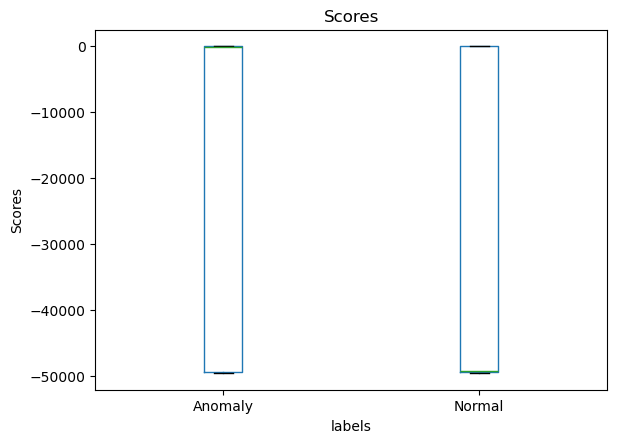

In [10]:
results.boxplot(column='scores', by='labels', grid=False)
plt.title('Scores')
plt.suptitle('')  # Remove the automatic title
plt.xticks(ticks=[1, 2], labels=['Anomaly', 'Normal'])
plt.ylabel('Scores')
plt.show()

In [11]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_targets, test_scores)
print("AUC Score: ", round(auc, 3))

AUC Score:  0.538
